#### Импорт необходимых объектов

In [1]:
import os
import csv
import numpy as np
from scipy.interpolate import splrep, splev
import pickle
#from sklearn.externals import joblib
import joblib

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Lars, LarsCV
from sklearn.linear_model import LassoLars, LassoLarsCV
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR, SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt

#### Функция чтения набора данных

In [2]:
# !!!
def get_river_dataset(fname, pr_list=None, y_name='H_max'):
    pr_arr = []
    y_arr = []
    with open(fname, newline='') as f:
        reader = csv.DictReader(f, delimiter=';')
        for row in reader:
            pr_arr_row = []
            for pr in pr_list:
                pr_arr_row.append(row[pr])

            pr_arr.append(pr_arr_row)
            y_arr.append(row[y_name])
    X = np.asarray(pr_arr, dtype=np.float64)
    y = np.asarray(y_arr, dtype=np.float64)
    return X, y

#### Среднеквадратическая погрешность прогноза S

In [3]:
#!!!
def get_s(h_max, h_forecast):
    # Среднеквадратическая погрешность прогноза
    n = h_max.shape[0]
    sqr_diff = np.sum((h_max - h_forecast) ** 2) / (n - 1)
    std = sqr_diff ** 0.5
    return std    

#### Среднеквадратическое отклонение sigma

In [4]:
#!!!
def get_sigma(h_max):
    # Среднеквадратическая погрешность климатическая.
    # Рассчитывается только по всей совокупности данных.
    return np.std(h_max, ddof=1)

#### Допустимая погрешность прогноза delta_dop

In [5]:
#!!!
def get_delta_dop(sigma):
    return 0.674 * sigma

#### Критерий критерий применимости и качества методики S/sigma

In [6]:
#!!!
def get_criterion(s, sigma):
    return s / sigma

#### Обеспеченность метода (оправдываемость) Pm

In [7]:
#!!!
def get_pm(h_max, h_forecast, delta_dop):
    diff = np.abs(h_max - h_forecast) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Корреляционное отношение

In [8]:
#!!!
def get_correlation_ratio(criterion):
    c_1 = (1 - criterion ** 2)
    ro = c_1 ** 0.5 if c_1 > 0 else 0
    return ro

#### Функция записи списка моделей с их характеристиками в csv файл

In [9]:
#!!!
def write_dataset_csv(year, dataset, dataset_name, fieldnames, pr_group, mode='training'):
    if mode == 'estimation':
        dir_path = f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/'
        file_name = f'{dataset_name}-гр{pr_group}-Оценка.csv'
    elif mode == 'training':
        dir_path = f'results/Models/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Обучение.csv'
    elif mode == 'forecast':
        dir_path = f'results/Forecast/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Прогноз.csv'
    else:
        ...
    
    with open(
        f'{dir_path}'
        f'{file_name}', 
        'w', newline='', encoding='utf-8'
    ) as csvfile:
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        writer.writeheader()
        writer.writerows(dataset)


#### Функция разделения набора данных на тренировочный и тестовый

In [10]:
#!!! -------->
def train_test_split(X, y, n_test, split=True):
    if split:   
        X_train = X[:-n_test].copy()
        y_train = y[:-n_test].copy()
        X_test = X[-n_test:].copy()
        y_test = y[-n_test:].copy()
    else:
        X_train = X.copy()
        y_train = y.copy()
        X_test = X.copy()
        y_test = y.copy()
    return X_train, y_train, X_test, y_test

#### Функция перемешивания данных

In [11]:
#!!! ------->
def shuffle_xy(X, y, shuffle=True):
    if shuffle:
        # Перемешивание данных
        Xy = np.column_stack((X, y))
        rng = np.random.default_rng(42)
        rng.shuffle(Xy)
        y_sh = Xy[:, -1]
        X_sh = Xy[:,:-1]
    else:
        y_sh = y.copy()
        X_sh = X.copy()
    return X_sh, y_sh

#### Функция формирования тестового набора данных с подстановкой нормированных значений

In [12]:
#!!!
def test_norm(x, pr_list, norms):
    x_norm = np.copy(x)
    for col, pr in enumerate(pr_list):
        if pr in norms:
            x_norm[:, col:col+1] = norms[pr]
    return x_norm

#### Функция получения датасетов

In [13]:
#!!!
def get_datasets():
    datasets = {
        'Неман-Белица': 'Неман',
        'Неман-Гродно': 'Неман',
        'Неман-Мосты': 'Неман',
        'Неман-Столбцы': 'Неман',

        'Вилия-Стешицы': 'Вилия',
        'Вилия-Михалишки': 'Вилия',
    }
    return datasets

#### Функция получения списка предикторов по названию датасета

In [14]:
# !!!
def get_predictors(dataset_name, group=None):

    datasets = get_datasets()   
    predictors_lists = {
        'Неман': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'],
        ),
        'Вилия': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs', 'L_max', 'L_2802', 'Q12', 'Q01', 'Q02', 'Y_sum'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3', 'L_max', 'Y_sum'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs', 'L_2802', 'Y_sum'],
        )
    }
    result = predictors_lists[datasets[dataset_name]] if group is None else \
             predictors_lists[datasets[dataset_name]][group]
    return result
    

#### Функция получения нормированных значений предикторов

In [15]:
#!!!
def get_norms(dataset_name):
    norms_list = {
        'Неман-Белица': {'X1': 46.0, 'X2':35.0},
        'Неман-Гродно': {'X1': 36.0, 'X2':26.0},
        'Неман-Мосты': {'X1': 40.0, 'X2':31.0},
        'Неман-Столбцы': {'X1': 43.0, 'X2':34.0},

        'Вилия-Стешицы': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0},
        'Вилия-Михалишки': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0},
    }
    return norms_list[dataset_name]

    

#### Функция получения аугментированных данных

In [16]:
def augment_data(x_data, y_data, aug_n, aug_pow=2, mirror=True, s=None):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=aug_pow, s=s)
        x_points_n = np.linspace(0, data_len, aug_n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=aug_pow, s=s)
    y_points_n = np.linspace(0, data_len, aug_n)
    y_augmented = splev(y_points_n, y_spl)
        
    
    x_aug_round = np.round(x_augmented, decimals=-1)
    y_aug_round = np.round(y_augmented, decimals=1)

    x_data_round = np.round(x_data, decimals=-1)
    y_data_round = np.round(y_data, decimals=1)
    
    
    mx = (x_aug_round[:, None] == x_data_round).all(-1).any(1)
    x_aug_clear = x_augmented[~mx].copy()
    y_aug_clear = y_augmented[~mx].copy()
    
    # my = np.in1d(y_aug_round, y_data_round)
    # x_aug_clear = x_aug_clear[~my]
    # y_aug_clear = y_aug_clear[~my]
    
    print('x_aug_clear.shape', x_aug_clear.shape)
    print('x_augmented.shape', x_augmented.shape)

    if mirror:
        x_mirror = np.mean(x_augmented) - x_augmented + np.mean(x_augmented)
        y_mirror = np.mean(y_augmented) - y_augmented + np.mean(y_augmented)
    
        x_result = np.vstack((x_aug_clear, x_mirror))
        y_result = np.hstack((y_aug_clear, y_mirror))
    else:
        x_result = x_aug_clear
        y_result = y_aug_clear
    
    if mirror:
        ...
        plt.plot(y_points, y_data, 'o', y_points_n, y_mirror)
        plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_mirror[:, 0])

    
    plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented[:, 0])
    plt.show()

    
    
    points_aug_clear = np.linspace(0, y_points, len(y_aug_clear))

    
    
    # plt.plot(y_points, y_data, 'o', points_aug_clear, y_aug_clear)
    # plt.plot(x_points, x_data[:, 0], 'x', points_aug_clear, x_aug_clear[:, 0])
    # plt.show()

    x_result[x_result < 0] = 0
    y_result[y_result < 0] = 0
    
    return x_result, y_result

#### Функция получения трансформеров входных данных

In [17]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=n_samples, random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=n_samples, random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция получения списка моделей регрессоров

In [18]:
def get_regressors_list():
    names = [
        # 'LinearRegression',
        
        # 'Ridge',
        # 'RidgeCV',
        
        # 'ElasticNetCV',
        
        # 'LassoCV',

        # 'LarsCV',
        
        # 'Lars1',
        # 'Lars2',
        # 'Lars3',
        # 'Lars4',
        # 'Lars5',
        'Lars6',
        # 'Lars7',
        # 'Lars8',

        # 'LassoLarsCV',
        
        # 'OMPCV',
        # 'OMP1',
        # 'OMP2',
        # 'OMP3',
        # 'OMP4',
        # 'OMP5',
        # 'OMP6',
        # 'OMP7',
        # 'OMP8',
        
        # 'BayesianRidge',
        # 'BayesianRidgeCV',
        # 'ARDRegression',
        #'ARDRegressionCV',
        # 'SGDRegressor', 
        # 'PassiveAggressiveRegressor',
        # # 'HuberRegressor',
        # 'HuberRegressorCV',
        # 'TheilSenRegressor',
        # # 'TheilSenRegressorCV',
        # 'QuantileRegressor',
        # # 'QuantileRegressorCV',
        
        
        'KNeighborsRegressor',
        # # # 'NuSVR',
        # # # 'SVR',
        # # # 'MLPRegressor',
        
        # 'RandomForestRegressor',
        # 'ExtraTreesRegressor',
        # 'HistGradientBoostingRegressor',
        # 'BaggingRegressor',
        # 'VotingRegressor',
        # 'StackingRegressorRidge',
        # 'AdaBoostRegressor',
    ]
    return names

#### Функция получения объектов моделей регрессии

In [19]:
def get_regressors_objects():
    # Инициализация генератора случайных чисел для
    # для обеспечения воспроизводимости результатов
    rng = np.random.RandomState(0)

    # Наборы гиперпараметров моделей для алгоритма кроссвалидации
    # Гиперпараметры для Ridge, Lasso, ElasticNet, LassoLars, HuberRegressor
    alphas = np.logspace(-4, 3, num=100)
    
    # Гиперпараметры для ElasticNet
    l1_ratio = np.linspace(0.01, 1.0, num=50)
    
    # Гиперпараметры для BayesianRidge
    alphas_init = np.linspace(0.5, 2, 5)
    lambdas_init = np.logspace(-3, 1, num=5)
    
    # Гиперпараметры для ARDRegression
    alphas_lambdas = np.logspace(-7, -4, num=4)
    
    # Гиперпараметры для SGDRegressor
    losses = ['squared_error', 'huber', 
              'epsilon_insensitive', 'squared_epsilon_insensitive']
    sgd_alphas = np.logspace(-4, 1, num=100)
   
    # Гиперпараметры для PassiveAggressiveRegressor
    cc = np.linspace(0.1, 1.5, 50)
    
    # Гиперпараметры для HuberRegressor
    epsilons = np.append(np.linspace(1.1, 2.0, 10), [1.35])
    
    # Гиперпараметры для TheilSenRegressor
    # n_subsamples = np.arange(15, 24)
    n_subsamples = (16, 24, 32)
    
    # Гиперпараметры для QuantileRegressor
    # q_alphas = np.linspace(0, 1, 5)
    q_alphas = (0.1, 1, 2)    
    
    regressors = [
        # LinearRegression(),
        
        # Ridge(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=Ridge(random_state=0), 
        #     param_grid={"alpha": alphas}
        # ),
        # RidgeCV(),

        # ElasticNetCV(random_state=0),
        
        # LassoCV(max_iter=10000, n_alphas=300, random_state=0),  
        
        # LarsCV(),
        
        # Lars(n_nonzero_coefs=1, random_state=0),
        # Lars(n_nonzero_coefs=2, random_state=0),
        # Lars(n_nonzero_coefs=3, random_state=0),
        # Lars(n_nonzero_coefs=4, random_state=0),
        # Lars(n_nonzero_coefs=5, random_state=0),
        Lars(n_nonzero_coefs=6, random_state=0),
        # Lars(n_nonzero_coefs=7, random_state=0),
        # Lars(n_nonzero_coefs=8, random_state=0),

        # LassoLarsCV(max_iter=500, max_n_alphas=1000),

        # OrthogonalMatchingPursuitCV(n_jobs=-1),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=2),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=3),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=4),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=5),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=6),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=7),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=8),
        
        # BayesianRidge(),
        # BayesianRidge() if not grid_search else \
        # GridSearchCV(
        #     estimator=BayesianRidge(),
        #     param_grid={"alpha_init": alphas_init, "lambda_init": lambdas_init}, 
        #     n_jobs=-1
        # ),

        # ARDRegression(),
        # ARDRegression() if not grid_search else \
        # GridSearchCV(
        #     estimator=ARDRegression(), 
        #     param_grid={"alpha_1": alphas_lambdas, "alpha_2": alphas_lambdas,
        #                 "lambda_1": alphas_lambdas,"lambda_2": alphas_lambdas}, 
        #     n_jobs=-1
        # ),

        # SGDRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=SGDRegressor(random_state=0), 
        #     param_grid={"loss": losses, "alpha": sgd_alphas}, 
        #     n_jobs=-1
        # ),

        # PassiveAggressiveRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=PassiveAggressiveRegressor(random_state=0), 
        #     param_grid={"C": cc}, 
        #     n_jobs=-1, 
        #     cv=3
        # ),

        # # HuberRegressor(max_iter=1000),
        # HuberRegressor(max_iter=1000) if not grid_search else \
        # GridSearchCV(
        #     estimator=HuberRegressor(), 
        #     param_grid={"epsilon": epsilons, "alpha": alphas}, 
        #     n_jobs=-1 
        # ),

        # TheilSenRegressor(random_state=0, n_jobs=-1),
        # TheilSenRegressor(random_state=0, n_jobs=-1) if not grid_search else \
        # GridSearchCV(
        #     estimator=TheilSenRegressor(random_state=0, n_jobs=-1), 
        #     param_grid={"n_subsamples": n_subsamples}, 
        #     n_jobs=-1
        # ),

        # QuantileRegressor(),
        # QuantileRegressor() if not grid_search else \
        # GridSearchCV(
        #     estimator=QuantileRegressor(), 
        #     param_grid={"alpha": q_alphas}, 
        #     n_jobs=-1
        # ),
        
        
        
        KNeighborsRegressor(n_neighbors=10, metric='euclidean'),
        # # NuSVR(C=5.0, nu=0.9, kernel='poly', degree=3),
        # # SVR(C=5.0, epsilon=0.2, kernel='poly', degree=3),
        
        
        # # MLPRegressor(
        # #     hidden_layer_sizes=(3, ), 
        # #     activation='identity', 
        # #     max_iter=100000, 
        # #     early_stopping=True, 
        # #     learning_rate='constant',
        # #     learning_rate_init=0.00025,
        # #     batch_size=75,
        # #     solver='adam',
        # #     random_state=0
        # # ),
       
        
        
        # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0),
        # ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0),
        # HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0),
        # BaggingRegressor(
        #     #KNeighborsRegressor(n_neighbors=20, metric='euclidean'),
        #     estimator=ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0), 
        #     max_samples=0.75, max_features=0.75, n_estimators=10, random_state=0
        # ),

        # VotingRegressor(
        #     estimators=[
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('omp', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)), 
        #         ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #     ]
        # ),


        # StackingRegressor( # RidgeCV - final estimator
        #     estimators=[
        #         ('knr', KNeighborsRegressor(n_neighbors=10, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('etr', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)),
        #         ('omp', OrthogonalMatchingPursuit(n_nonzero_coefs=5)),
        #     ],
        # ),

        # AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors=5, metric='euclidean'), n_estimators=100, loss='linear', random_state=0),
        
    ]
    return regressors

#### Функция обучения моделей на полном наборе данных с записью на диск

In [20]:
def train_models(year, pr_group, n_test=None, norms=True, aug_n=0, aug_pow=2, aug_mirror=False, grid_search=False, scaler_x=None, scaler_y=None, shuffle=True, serial=True, top_best=None):
    
    ds_dir = f'data/{year}/Train'
    
    

    datasets = get_datasets()

    fieldnames = [
        'Predictors', 
        'Equations', 
        'Method', 
        'Criterion', 
        'Correlation', 
        'Pm',
        'R2',

        'Criterion_t', 
        'Correlation_t', 
        'Pm_t',
        'R2_t',

        'Criterion_f', 
        'Correlation_f', 
        'Pm_f',
        'R2_f',

        # 'Group',
        # 'Augmentation',
        # 'Data size',
        # 'Normalization',
        # 'Equations',
    ]

    # Описание структуры данных переменной datasets_result
    # datasets_result = {
    #     "hydropost_0": [
    #         { model_row }
    #         { model_row }
    #     ],
    #     ...,
    #     "hydropost_n": [
    #         { model_row }
    #         { model_row }
    #     ],
    # }
    
    
    # Итерация по датасетам
    datasets_result = dict()
    for ds in datasets:

        # Получить все группы по датасету
        ds_groups = get_predictors(ds)
        
        # Итерация по группам предикторов
        for group, pr_list in enumerate(ds_groups):

            if pr_group is not None:
                if group != pr_group:
                    continue
        
            result_list = []
            
            X, y = get_river_dataset(f'{ds_dir}/{ds}.csv', pr_list=pr_list)
    
            # Проверочный набор данных (исходный)
            X_prior = X.copy()
            y_prior = y.copy()
            
            # Полный набор данных
            X_full = X.copy()
            y_full = y.copy()

            if aug_n:
                X_full, y_full = augment_data(X_full, y_full, aug_n, aug_pow=aug_pow, mirror=aug_mirror)
            
            if shuffle:
                X_full, y_full = shuffle_xy(X_full, y_full, shuffle=True)
            
            if n_test:
                X_train, y_train, X_test, y_test = train_test_split(X_full, y_full, n_test, split=True)
    
            # print("SHAPES:")
            # print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
            # print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)
            
            norms_data = None
            if norms:
                norms_data = get_norms(ds)
                # Подстановка норм в исходный набор данных (пессимистичный сценарий)
                X_prior = test_norm(X_prior, pr_list, norms_data)
                # Подстановка норм в тестовый набор данных
                X_test = test_norm(X_test, pr_list, norms_data)
                # Подстановка норм в полный набор данных не требуется
  
            # print("X_test:")
            # print(X_test)
            # print("X_train:")
            # print(X_train)

            transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
            transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
            transformer_y_full = get_transformer(scaler_y, n_samples=y_full.shape[0]) # !!!
            transformer_x_full = get_transformer(scaler_x, n_samples=y_full.shape[0]) # !!!
            print(transformer_y)
            print(transformer_x)

            # Список оцениваемых ререссионных моделей !!!!!
            names = get_regressors_list()
            regressors = get_regressors_objects()
            regressors_full = get_regressors_objects()
                
            # Итерация по моделям регрессии
            for name, model, model_full in zip(names, regressors, regressors_full):

                # Препроцессинг - трансформация целевых значений y
                if scaler_y: 
                    regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
                    regressor_full = TransformedTargetRegressor(regressor=model_full, transformer=transformer_y_full)
                else:
                    regressor = model
                    regressor_full = model_full
                
                one_model_row = dict()
                print('X_full.shape', X_full.shape)
                print('y_full.shape', y_full.shape)
                print('X_train.shape', X_train.shape)
                print('y_train.shape', y_train.shape)
                print('X_test.shape', X_test.shape)
                print('y_test.shape', y_test.shape)
                # n_samples = min(10000, y_train.shape[0])
                
                
                # Препроцессинг - трансформация признаков X
                regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor
                regr_full = make_pipeline(transformer_x_full, regressor_full) if transformer_x_full else regressor_full
                
                # Обучение на тренировочном наборе
                regr = regr.fit(X_train, y_train)
                try:
                    regr.fit(X_train, y_train)
                except ValueError as error:
                    print('Ошибка обучения на тренировочном наборе данных:')
                    print(error)
                    continue
                if serial:
                    serial_model = pickle.dumps(regr)
                    regr = pickle.loads(serial_model)
                
                # Обученная на тренировочном наборе данных модель
                one_model_row['Model_train'] = regr
                    
                # Прогноз по исходному набору на тренировочной модели
                y_predicted_prior = np.ravel(regr.predict(X_prior))
                
                # Прогноз по тестовому набору на тренировочной модели 
                y_predicted_test = np.ravel(regr.predict(X_test))
    
                
                # Очистка значений строк предикторов и уравнений перед переходом к следующей модели
                coef = None
                intercept = None
                
                try:
                    coef = regr.best_estimator_.coef_
                    intercept = regr.best_estimator_.intercept_
                    
                    if isinstance(intercept, np.ndarray):
                        intercept = intercept[0]
                except Exception as error:
                                    
                    try:
                        coef = regr.coef_
                        intercept = regr.intercept_
                    
                        if isinstance(intercept, np.ndarray):
                            intercept = intercept[0]
                        print("ERROR1 START")
                        print(error)
                        print("ERROR1 FINISH")
                    except Exception as error:
                        print("ERROR2 START")
                        print(error)
                        print("ERROR2 FINISH")
                    
                
                try:
                    # Коэффициенты уравнения (если есть)
                    coef = np.around(np.ravel(coef), 3)
                    intercept = round(intercept, 3)
                    
                    predictors_coef = {f: c for f, c 
                                       in zip(pr_list, coef) if c != 0.0}
                    
                    predictors = ", ".join(predictors_coef.keys())
                    
                    equation = (
                        str(intercept) 
                        + ' ' 
                        + ' '.join(str(c) + '*' 
                                   + f for f, c in predictors_coef.items())
                    )
                    
                    equation = equation.replace(" -", "-")
                    equation = equation.replace(" ", " + ")
                    equation = equation.replace("-", " - ")
        
                    one_model_row['Predictors'] = predictors
                    one_model_row['Equations'] = equation
                except Exception as error:
                    print("ERROR3 START")
                    print(error)
                    print("ERROR3 FINISH")
                    one_model_row['Predictors'] = ""
                    one_model_row['Equations'] = ""
    
                # Год прогноза
                one_model_row['Forecast_year'] = year
                    
                # Название датасета
                one_model_row['Dataset_name'] = ds

                # Название датасета
                one_model_row['Predictors_list'] = pr_list

                # Нормы
                one_model_row['Norms_data'] = norms_data
    
                # Группа предикторов
                one_model_row['Group'] = group
                    
                # Название метода
                one_model_row['Method'] = name
                
                # Среднеквадратическое отклонение
                # по исходному набору:
                sigma = get_sigma(y_prior) #!!!
                one_model_row['Sigma'] = sigma
                # по тестовому набору:
                sigma_t = get_sigma(y_test) #!!!
                one_model_row['Sigma_t'] = sigma_t
                
                # Допустимая погрешность прогноза
                # по исходному набору:
                delta_dop = get_delta_dop(sigma) #!!!
                one_model_row['Delta_dop'] = delta_dop
                # по тестовому набору:
                delta_dop_t = get_delta_dop(sigma_t) #!!!
                one_model_row['Delta_dop_t'] = delta_dop_t
    
                # Обеспеченность метода (оправдываемость) Pm
                # по исходному набору:
                pm = get_pm(y_prior, y_predicted_prior, delta_dop) #!!!
                one_model_row['Pm'] = pm
                # по тестовому набору:
                pm_t = get_pm(y_test, y_predicted_test, delta_dop_t) #!!!
                one_model_row['Pm_t'] = pm_t
    
                # Среднеквадратическая погрешность прогноза
                # по исходному набору:
                s_forecast = get_s(y_prior, y_predicted_prior) #!!!
                one_model_row['S'] = s_forecast
                # по тестовому набору:
                s_forecast_t = get_s(y_test, y_predicted_test) #!!!
                one_model_row['S_t'] = s_forecast_t
                
                # Критерий эффективности метода прогнозирования 
                # климатический S/sigma
                # по исходному набору:
                criterion_forecast = get_criterion(s_forecast, sigma) #!!!
                one_model_row['Criterion'] = criterion_forecast
                # по тестовому набору:
                criterion_forecast_t = get_criterion(s_forecast_t, sigma_t) #!!!
                one_model_row['Criterion_t'] = criterion_forecast_t
    
                
                # Корреляционное отношение ro
                # по исходному набору:
                correlation_forecast = get_correlation_ratio(criterion_forecast)
                one_model_row['Correlation'] = correlation_forecast
                # по тестовому набору:
                correlation_forecast_t = get_correlation_ratio(criterion_forecast_t)
                one_model_row['Correlation_t'] = correlation_forecast_t
                
                
                # Коэффициент детерминации R2
                # по исходному набору:
                one_model_row['R2'] = regr.score(X_prior, y_prior)
                # по тестовому набору:
                one_model_row['R2_t'] = regr.score(X_test, y_test)
                
    
                # Обучение на полном наборе данных
                try:
                    regr_full = regr_full.fit(X_full, y_full)
                except ValueError as error:
                    print('Ошибка обучения на полном наборе данных:')
                    print(error)
                    continue
                if serial:
                    serial_model_full = pickle.dumps(regr_full)
                    regr_full = pickle.loads(serial_model_full)

                # Обученная на полных данных модель
                one_model_row['Model_full'] = regr_full
    
                # Прогноз по полному набору (производится на "тестовых" данных) 
                y_predicted_full = np.ravel(regr_full.predict(X_test))         
    
                # по полному набору:
                sigma_f = get_sigma(y_test) #!!!
                one_model_row['Sigma_f'] = sigma_f
    
                # по полному набору:
                delta_dop_f = get_delta_dop(sigma_f) #!!!
                one_model_row['Delta_dop_f'] = delta_dop_f
    
                # по полному набору:
                pm_f = get_pm(y_test, y_predicted_full, delta_dop_f) #!!!
                one_model_row['Pm_f'] = pm_f
    
                # по полному набору:
                s_forecast_f = get_s(y_test, y_predicted_full) #!!!
                one_model_row['S_f'] = s_forecast_f
    
                # по полному набору:
                criterion_forecast_f = get_criterion(s_forecast_f, sigma_f) #!!!
                one_model_row['Criterion_f'] = criterion_forecast_f
               
                # по полному набору:
                correlation_forecast_f = get_correlation_ratio(criterion_forecast_f)
                one_model_row['Correlation_f'] = correlation_forecast_f
                
                # Коэффициент детерминации R2
                # по полному набору:
                one_model_row['R2_f'] = regr_full.score(X_test, y_test)
    
                print(one_model_row)
    
                
                # Добавление результатов модели в результирующий список по датасету
                result_list.append(one_model_row)
    
                # Запись сериализованного объекта {модель, статистика} в файл
                write_model(one_model_row)

                
                #----------------------------------------------------------------------------------------------
                smodel = pickle.dumps(one_model_row)
                # with open(f'results/Models/{year}/Вилия-Стешицы_2024_гр0_OMP7.pickle', 'rb') as f:
                #     model_info = pickle.load(f, encoding="latin1")
                model_info = pickle.loads(smodel)
                model_full = model_info['Model_full']
                # model_train = model_info['Model_train']
                # Прогноз по исходному набору
                pickled_y_predicted_prior = np.ravel(model_full.predict(X_prior))

                print('------------------------------------------------------------------------------')
                print('predicted_prior train model')
                print(y_predicted_prior)
                
                
                print(name)
                print(y_prior)
                print('predicted_prior full model')
                print(pickled_y_predicted_prior)
                print('------------------------------------------------------------------------------')
                #----------------------------------------------------------------------------------------------
                # Конец итерации по модели
    
            # Сортировка результатов по каждому датасету
            result_list.sort(
                key=lambda row: (row['Criterion'], 
                                 -row['Correlation'], 
                                 -row['Pm'])
            )
    
            datasets_result[ds] = result_list
    
            # Запись в .csv файл
            write_dataset_csv(year, result_list, ds, fieldnames, pr_group=group, mode='training')
        
            # Конец итерации по группе
        
        # Конец итерации по датасету
       
    return datasets_result

### Запись сериализованного объекта {модель, статистика} в файл

In [21]:
def write_model(model_row):
    dir_path = f'results/Models/{model_row["Forecast_year"]}'
    
    with open(f'{dir_path}/'
              f'{model_row["Dataset_name"]}_'
              f'{model_row["Forecast_year"]}_'
              f'гр{model_row["Group"]}_'
              f'{model_row["Method"]}.pickle', 'wb') as pf:
        pickle.dump(model_row, pf) #, pickle.HIGHEST_PROTOCOL
        

#### Запуск процесса обучения моделей множественной регрессии

x_aug_clear.shape (924, 8)
x_augmented.shape (1000, 8)


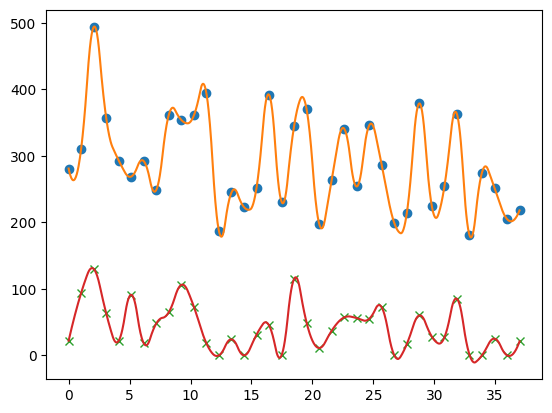

None
None
X_full.shape (924, 8)
y_full.shape (924,)
X_train.shape (824, 8)
y_train.shape (824,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X, X1, X2, X3', 'Equations': '79.797 + 1.394*S_2802 + 0.292*H_2802 + 0.379*X + 0.137*X1 + 0.571*X2 + 0.21*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Белица', 'Predictors_list': ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 46.0, 'X2': 35.0}, 'Group': 0, 'Method': 'Lars6', 'Sigma': 72.8157718948075, 'Sigma_t': 72.8849223123174, 'Delta_dop': 49.07783025710026, 'Delta_dop_t': 49.12443763850193, 'Pm': 78.37837837837837, 'Pm_t': 84.0, 'S': 45.52304864834927, 'S_t': 44.282668559003355, 'Criterion': 0.6251811587483223, 'Criterion_t': 0.6075696749630709, 'Correlation': 0.7804796722183769, 'Correlation_t': 0.7942663848264437, 'R2': 0.6091485187461052, 'R2_t

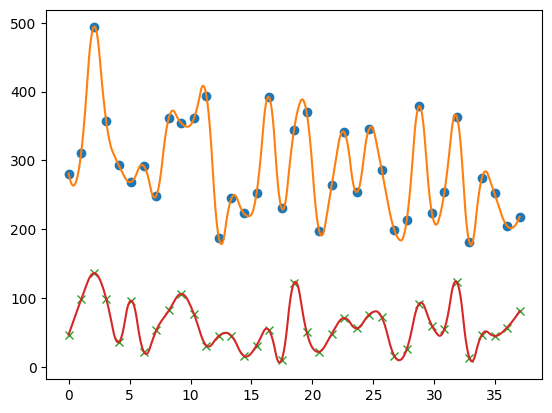

None
None
X_full.shape (888, 5)
y_full.shape (888,)
X_train.shape (788, 5)
y_train.shape (788,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'Smax, H_2802, X, X1, X3', 'Equations': '73.478 + 1.352*Smax + 0.157*H_2802 + 0.504*X + 0.353*X1 + 0.28*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Белица', 'Predictors_list': ['Smax', 'H_2802', 'X', 'X1', 'X3'], 'Norms_data': {'X1': 46.0, 'X2': 35.0}, 'Group': 1, 'Method': 'Lars6', 'Sigma': 72.8157718948075, 'Sigma_t': 71.91740956841754, 'Delta_dop': 49.07783025710026, 'Delta_dop_t': 48.47233404911343, 'Pm': 75.67567567567568, 'Pm_t': 80.0, 'S': 51.793426846139134, 'S_t': 42.10576480994986, 'Criterion': 0.7112940713031504, 'Criterion_t': 0.585473879866226, 'Correlation': 0.7028945469478255, 'Correlation_t': 0.8106912704565086, 'R2': 0.49406074412898904, 'R2_t': 0.657220335994388, 'Model_full': Lars

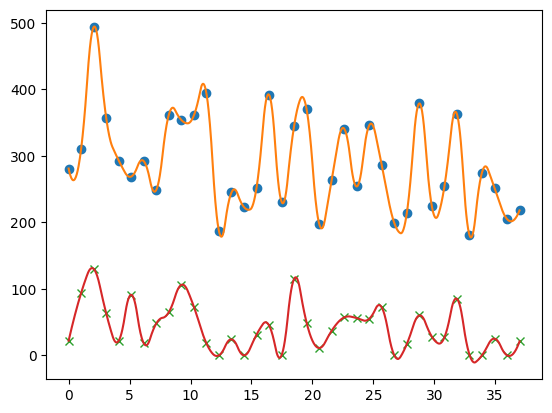

None
None
X_full.shape (897, 5)
y_full.shape (897,)
X_train.shape (797, 5)
y_train.shape (797,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X2, X3, Xs', 'Equations': '92.101 + 1.515*S_2802 + 0.211*H_2802 + 0.818*X2 + 0.233*X3 + 0.265*Xs', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Белица', 'Predictors_list': ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 46.0, 'X2': 35.0}, 'Group': 2, 'Method': 'Lars6', 'Sigma': 72.8157718948075, 'Sigma_t': 69.9140244454028, 'Delta_dop': 49.07783025710026, 'Delta_dop_t': 47.12205247620149, 'Pm': 75.67567567567568, 'Pm_t': 82.0, 'S': 47.42126949395408, 'S_t': 42.19063210754707, 'Criterion': 0.6512499731852145, 'Criterion_t': 0.6034645043283775, 'Correlation': 0.758863276503915, 'Correlation_t': 0.7973898619970696, 'R2': 0.5758734724262575, 'R2_t': 0.6358305920157057, 'Model_ful

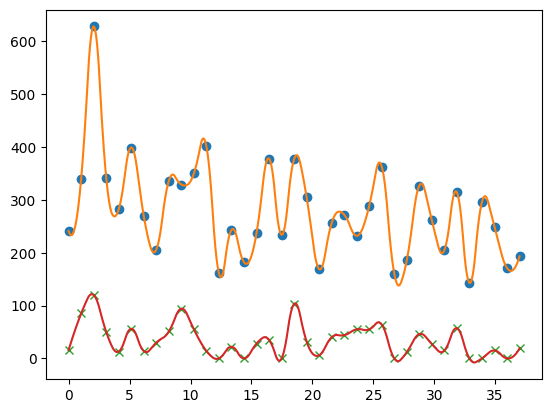

None
None
X_full.shape (929, 8)
y_full.shape (929,)
X_train.shape (829, 8)
y_train.shape (829,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, Smax, H_2802, X1, X3, Xs', 'Equations': '150.633 + 1.966*S_2802 + 0.331*Smax - 0.145*H_2802 + 0.353*X1 + 0.346*X3 + 0.086*Xs', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Гродно', 'Predictors_list': ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 36.0, 'X2': 26.0}, 'Group': 0, 'Method': 'Lars6', 'Sigma': 93.96700909786794, 'Sigma_t': 102.823790447585, 'Delta_dop': 63.333764131963, 'Delta_dop_t': 69.30323476167229, 'Pm': 75.67567567567568, 'Pm_t': 83.0, 'S': 57.43096957353908, 'S_t': 62.56447722443324, 'Criterion': 0.6111822662539352, 'Criterion_t': 0.6084630507404396, 'Correlation': 0.7914898845953142, 'Correlation_t': 0.793582204868303, 'R2': 0.626456237416704, '

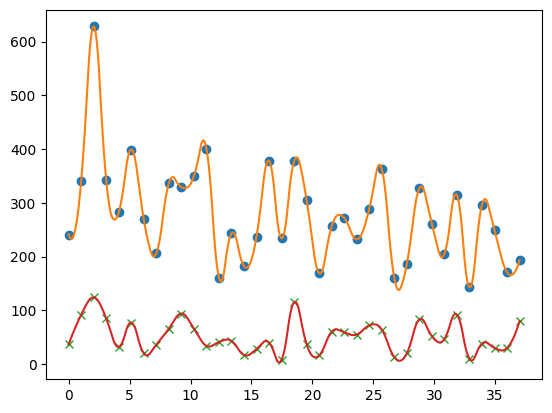

None
None
X_full.shape (899, 5)
y_full.shape (899,)
X_train.shape (799, 5)
y_train.shape (799,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'Smax, H_2802, X, X1, X3', 'Equations': '121.313 + 2.448*Smax - 0.194*H_2802 - 0.102*X + 0.498*X1 + 0.399*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Гродно', 'Predictors_list': ['Smax', 'H_2802', 'X', 'X1', 'X3'], 'Norms_data': {'X1': 36.0, 'X2': 26.0}, 'Group': 1, 'Method': 'Lars6', 'Sigma': 93.96700909786794, 'Sigma_t': 98.62659396181482, 'Delta_dop': 63.333764131963, 'Delta_dop_t': 66.47432433026319, 'Pm': 78.37837837837837, 'Pm_t': 83.0, 'S': 64.20151378571444, 'S_t': 57.838497122943906, 'Criterion': 0.6832346203426318, 'Criterion_t': 0.5864391620918917, 'Correlation': 0.7301989136976716, 'Correlation_t': 0.8099932772344224, 'R2': 0.5331904535652596, 'R2_t': 0.65608910916496, 'Model_full': Lars

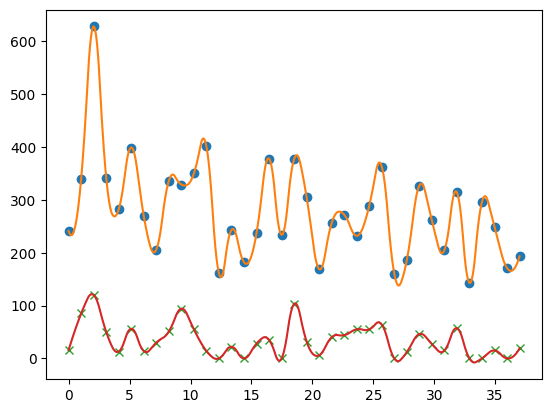

None
None
X_full.shape (897, 5)
y_full.shape (897,)
X_train.shape (797, 5)
y_train.shape (797,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X2, X3, Xs', 'Equations': '110.485 + 2.26*S_2802 - 0.106*H_2802 + 0.724*X2 + 0.436*X3 + 0.371*Xs', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Гродно', 'Predictors_list': ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 36.0, 'X2': 26.0}, 'Group': 2, 'Method': 'Lars6', 'Sigma': 93.96700909786794, 'Sigma_t': 99.21799383524143, 'Delta_dop': 63.333764131963, 'Delta_dop_t': 66.87292784495273, 'Pm': 75.67567567567568, 'Pm_t': 83.0, 'S': 57.69767373132035, 'S_t': 58.61803435019868, 'Criterion': 0.6140205406689855, 'Criterion_t': 0.5908004393591963, 'Correlation': 0.7892900453170347, 'Correlation_t': 0.8068177246770057, 'R2': 0.6229787756365668, 'R2_t': 0.6509548408529804, 'Model_fu

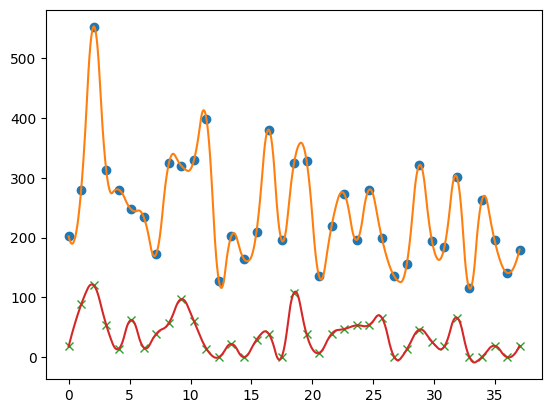

None
None
X_full.shape (903, 8)
y_full.shape (903,)
X_train.shape (803, 8)
y_train.shape (803,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, Smax, H_2802, X, X2, X3', 'Equations': '126.239 + 1.692*S_2802 + 0.001*Smax + 0.049*H_2802 + 0.154*X + 0.304*X2 + 0.201*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Мосты', 'Predictors_list': ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 40.0, 'X2': 31.0}, 'Group': 0, 'Method': 'Lars6', 'Sigma': 90.99731870781696, 'Sigma_t': 93.10674042744972, 'Delta_dop': 61.33219280906864, 'Delta_dop_t': 62.753943048101114, 'Pm': 75.67567567567568, 'Pm_t': 74.0, 'S': 63.94797196960272, 'S_t': 67.26392925860681, 'Criterion': 0.7027456729239802, 'Criterion_t': 0.7224388798254617, 'Correlation': 0.7114411565172641, 'Correlation_t': 0.6914347871755745, 'R2': 0.5061485191866222

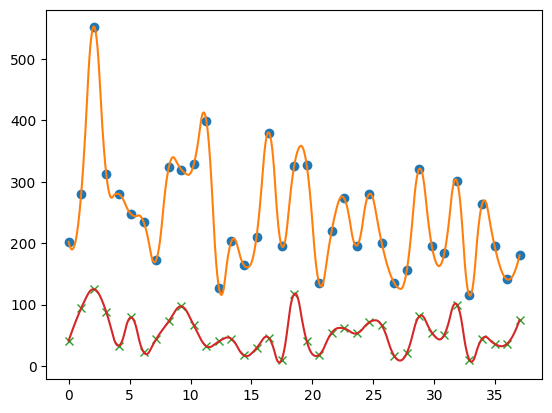

None
None
X_full.shape (860, 5)
y_full.shape (860,)
X_train.shape (760, 5)
y_train.shape (760,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'Smax, H_2802, X, X1, X3', 'Equations': '33.255 + 2.013*Smax - 0.039*H_2802 + 0.405*X + 0.764*X1 + 0.336*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Мосты', 'Predictors_list': ['Smax', 'H_2802', 'X', 'X1', 'X3'], 'Norms_data': {'X1': 40.0, 'X2': 31.0}, 'Group': 1, 'Method': 'Lars6', 'Sigma': 90.99731870781696, 'Sigma_t': 90.32408131886729, 'Delta_dop': 61.33219280906864, 'Delta_dop_t': 60.878430808916555, 'Pm': 70.27027027027027, 'Pm_t': 74.0, 'S': 67.6354481109963, 'S_t': 54.917735107865056, 'Criterion': 0.7432685827608478, 'Criterion_t': 0.6080076797459063, 'Correlation': 0.6689931344047416, 'Correlation_t': 0.7939311439728255, 'R2': 0.44755181388068066, 'R2_t': 0.6303266613699996, 'Model_full': L

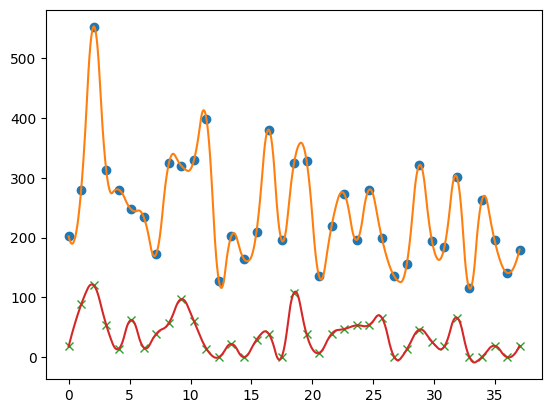

None
None
X_full.shape (869, 5)
y_full.shape (869,)
X_train.shape (769, 5)
y_train.shape (769,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X2, X3, Xs', 'Equations': '26.325 + 1.888*S_2802 + 0.158*H_2802 + 1.289*X2 + 0.387*X3 + 0.38*Xs', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Мосты', 'Predictors_list': ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 40.0, 'X2': 31.0}, 'Group': 2, 'Method': 'Lars6', 'Sigma': 90.99731870781696, 'Sigma_t': 91.49995609996866, 'Delta_dop': 61.33219280906864, 'Delta_dop_t': 61.67097041137888, 'Pm': 72.97297297297297, 'Pm_t': 79.0, 'S': 62.830868972988014, 'S_t': 56.23287170703708, 'Criterion': 0.6904694541026146, 'Criterion_t': 0.6145671987601788, 'Correlation': 0.7233615506447916, 'Correlation_t': 0.7888644739168236, 'R2': 0.5232519329512373, 'R2_t': 0.6223071582080668, 'Model_f

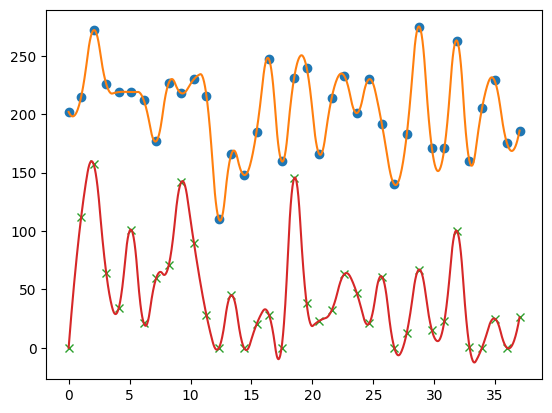

None
None
X_full.shape (932, 8)
y_full.shape (932,)
X_train.shape (832, 8)
y_train.shape (832,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, Smax, H_2802, X, X2, X3', 'Equations': '109.377 + 0.191*S_2802 + 0.32*Smax + 0.016*H_2802 + 0.153*X + 0.527*X2 + 0.183*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Столбцы', 'Predictors_list': ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 43.0, 'X2': 34.0}, 'Group': 0, 'Method': 'Lars6', 'Sigma': 37.17629051662601, 'Sigma_t': 36.43575745956925, 'Delta_dop': 25.056819808205933, 'Delta_dop_t': 24.557700527749677, 'Pm': 72.97297297297297, 'Pm_t': 75.0, 'S': 24.527984543737894, 'S_t': 23.245768943038833, 'Criterion': 0.659774931895598, 'Criterion_t': 0.6379932946044384, 'Correlation': 0.75146326539769, 'Correlation_t': 0.7700419183653409, 'R2': 0.564697039242158

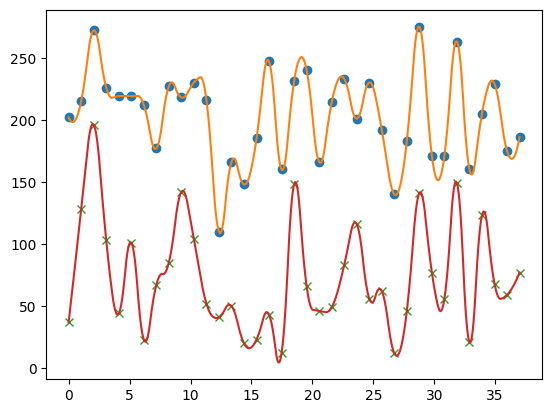

None
None
X_full.shape (903, 5)
y_full.shape (903,)
X_train.shape (803, 5)
y_train.shape (803,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'Smax, H_2802, X, X1, X3', 'Equations': '123.04 + 0.495*Smax - 0.192*H_2802 + 0.271*X + 0.187*X1 + 0.199*X3', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Столбцы', 'Predictors_list': ['Smax', 'H_2802', 'X', 'X1', 'X3'], 'Norms_data': {'X1': 43.0, 'X2': 34.0}, 'Group': 1, 'Method': 'Lars6', 'Sigma': 37.17629051662601, 'Sigma_t': 36.33001912030804, 'Delta_dop': 25.056819808205933, 'Delta_dop_t': 24.48643288708762, 'Pm': 67.56756756756756, 'Pm_t': 67.0, 'S': 24.89707304851798, 'S_t': 23.266198005588087, 'Criterion': 0.6697029935620794, 'Criterion_t': 0.6404124899725848, 'Correlation': 0.7426290463037313, 'Correlation_t': 0.7680311469511597, 'R2': 0.5514979004139895, 'R2_t': 0.5898718426871138, 'Model_full':

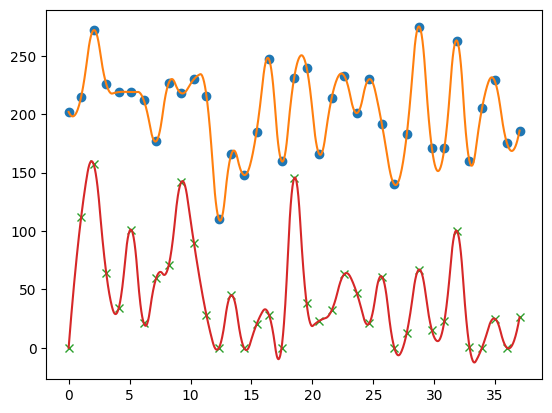

None
None
X_full.shape (890, 5)
y_full.shape (890,)
X_train.shape (790, 5)
y_train.shape (790,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X2, X3, Xs', 'Equations': '90.96 + 0.548*S_2802 + 0.165*H_2802 + 0.788*X2 + 0.188*X3 + 0.14*Xs', 'Forecast_year': 2024, 'Dataset_name': 'Неман-Столбцы', 'Predictors_list': ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'], 'Norms_data': {'X1': 43.0, 'X2': 34.0}, 'Group': 2, 'Method': 'Lars6', 'Sigma': 37.17629051662601, 'Sigma_t': 36.6219768749588, 'Delta_dop': 25.056819808205933, 'Delta_dop_t': 24.68321241372223, 'Pm': 59.45945945945946, 'Pm_t': 66.0, 'S': 27.702233762330124, 'S_t': 25.843306311357903, 'Criterion': 0.745158631411628, 'Criterion_t': 0.7056775334547524, 'Correlation': 0.6668872573627042, 'Correlation_t': 0.7085331458564355, 'R2': 0.4447386140327494, 'R2_t': 0.5020192187772169, 'Model_

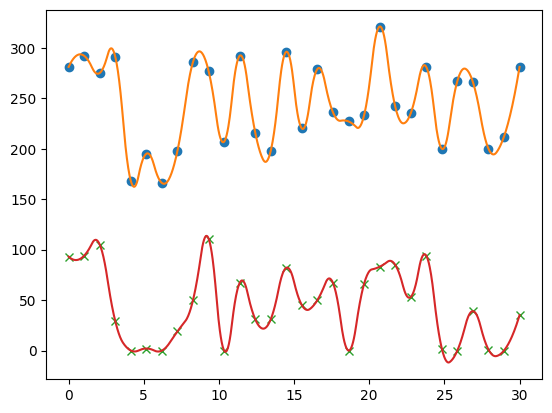

None
None
X_full.shape (931, 14)
y_full.shape (931,)
X_train.shape (831, 14)
y_train.shape (831,)
X_test.shape (100, 14)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X, X2, X3, L_2802', 'Equations': '161.43 + 0.527*S_2802 + 0.048*H_2802 + 0.284*X + 0.168*X2 + 0.055*X3 + 0.103*L_2802', 'Forecast_year': 2024, 'Dataset_name': 'Вилия-Стешицы', 'Predictors_list': ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs', 'L_max', 'L_2802', 'Q12', 'Q01', 'Q02', 'Y_sum'], 'Norms_data': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0}, 'Group': 0, 'Method': 'Lars6', 'Sigma': 42.4569558900338, 'Sigma_t': 36.94368810598366, 'Delta_dop': 28.61598826988278, 'Delta_dop_t': 24.90004578343299, 'Pm': 56.666666666666664, 'Pm_t': 73.0, 'S': 29.951448848500632, 'S_t': 23.40194264025142, 'Criterion': 0.705454459007301, 'Criterion_t': 0.6334490095606096

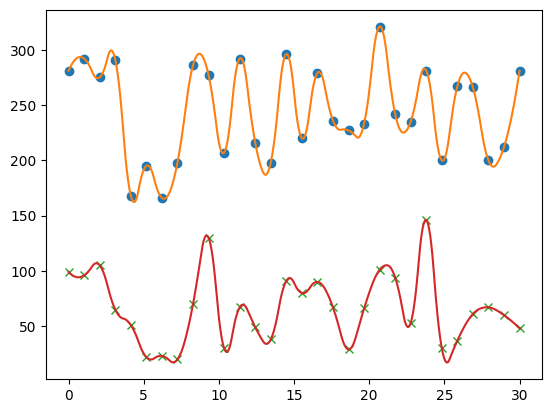

None
None
X_full.shape (908, 7)
y_full.shape (908,)
X_train.shape (808, 7)
y_train.shape (808,)
X_test.shape (100, 7)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'Smax, H_2802, X, X1, X3, L_max', 'Equations': '90.554 + 0.626*Smax + 0.212*H_2802 + 0.359*X + 0.084*X1 + 0.109*X3 + 0.282*L_max', 'Forecast_year': 2024, 'Dataset_name': 'Вилия-Стешицы', 'Predictors_list': ['Smax', 'H_2802', 'X', 'X1', 'X3', 'L_max', 'Y_sum'], 'Norms_data': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0}, 'Group': 1, 'Method': 'Lars6', 'Sigma': 42.4569558900338, 'Sigma_t': 36.712119906111525, 'Delta_dop': 28.61598826988278, 'Delta_dop_t': 24.743968816719168, 'Pm': 53.333333333333336, 'Pm_t': 64.0, 'S': 30.990488738867118, 'S_t': 24.88461146326448, 'Criterion': 0.7299272425261586, 'Criterion_t': 0.6778309595551822, 'Correlation': 0.6835248500370403, 'Correlation_t': 0.735

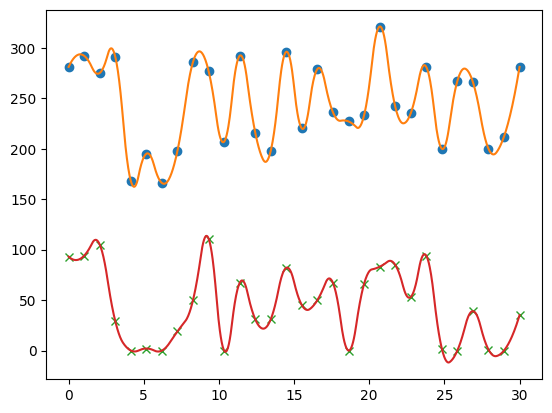

None
None
X_full.shape (898, 7)
y_full.shape (898,)
X_train.shape (798, 7)
y_train.shape (798,)
X_test.shape (100, 7)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X2, X3, Xs, L_2802', 'Equations': '76.599 + 0.806*S_2802 + 0.377*H_2802 + 0.693*X2 + 0.009*X3 + 0.249*Xs + 0.373*L_2802', 'Forecast_year': 2024, 'Dataset_name': 'Вилия-Стешицы', 'Predictors_list': ['S_2802', 'H_2802', 'X2', 'X3', 'Xs', 'L_2802', 'Y_sum'], 'Norms_data': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0}, 'Group': 2, 'Method': 'Lars6', 'Sigma': 42.4569558900338, 'Sigma_t': 37.54930443016742, 'Delta_dop': 28.61598826988278, 'Delta_dop_t': 25.30823118593284, 'Pm': 73.33333333333333, 'Pm_t': 76.0, 'S': 24.11474174114101, 'S_t': 20.253066343336258, 'Criterion': 0.5679809405930967, 'Criterion_t': 0.5393726102437407, 'Correlation': 0.8230417067943647, 'Correlation_

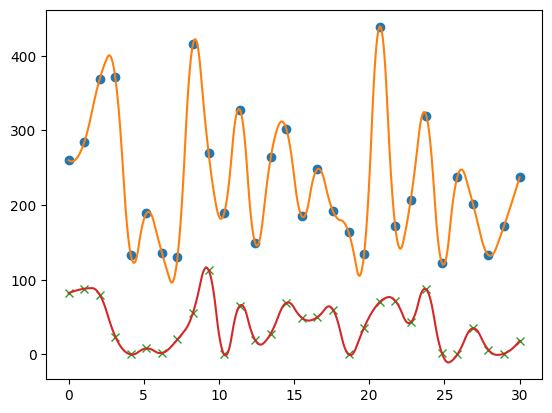

None
None
X_full.shape (932, 14)
y_full.shape (932,)
X_train.shape (832, 14)
y_train.shape (832,)
X_test.shape (100, 14)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, Smax, H_2802, X, X3, L_2802', 'Equations': '33.579 + 0.252*S_2802 + 0.342*Smax + 0.098*H_2802 + 0.458*X + 0.346*X3 + 0.921*L_2802', 'Forecast_year': 2024, 'Dataset_name': 'Вилия-Михалишки', 'Predictors_list': ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs', 'L_max', 'L_2802', 'Q12', 'Q01', 'Q02', 'Y_sum'], 'Norms_data': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0}, 'Group': 0, 'Method': 'Lars6', 'Sigma': 89.32302222188059, 'Sigma_t': 80.80087727185763, 'Delta_dop': 60.20371697754752, 'Delta_dop_t': 54.45979128123204, 'Pm': 63.33333333333333, 'Pm_t': 74.0, 'S': 59.196917840841664, 'S_t': 51.996078622392744, 'Criterion': 0.6627285594277705, 'Criterion_t': 0.64350883

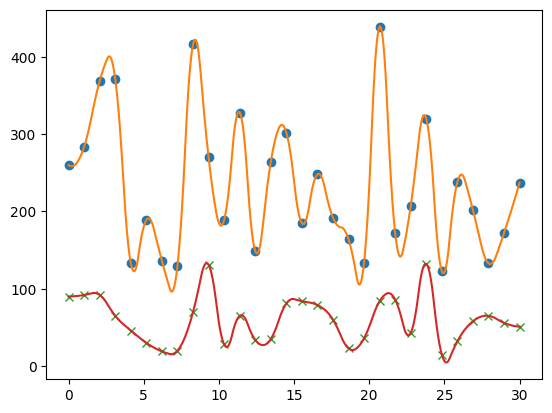

None
None
X_full.shape (901, 7)
y_full.shape (901,)
X_train.shape (801, 7)
y_train.shape (801,)
X_test.shape (100, 7)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'Smax, H_2802, X, X1, X3, L_max', 'Equations': ' - 84.678 + 0.897*Smax + 0.342*H_2802 + 0.437*X + 0.009*X1 + 0.488*X3 + 1.473*L_max', 'Forecast_year': 2024, 'Dataset_name': 'Вилия-Михалишки', 'Predictors_list': ['Smax', 'H_2802', 'X', 'X1', 'X3', 'L_max', 'Y_sum'], 'Norms_data': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0}, 'Group': 1, 'Method': 'Lars6', 'Sigma': 89.32302222188059, 'Sigma_t': 84.32106944507034, 'Delta_dop': 60.20371697754752, 'Delta_dop_t': 56.83240080597741, 'Pm': 73.33333333333333, 'Pm_t': 62.0, 'S': 67.80830504982991, 'S_t': 63.20364158876744, 'Criterion': 0.7591358125052285, 'Criterion_t': 0.7495592976313054, 'Correlation': 0.6509322684980569, 'Correlation_t': 0.6

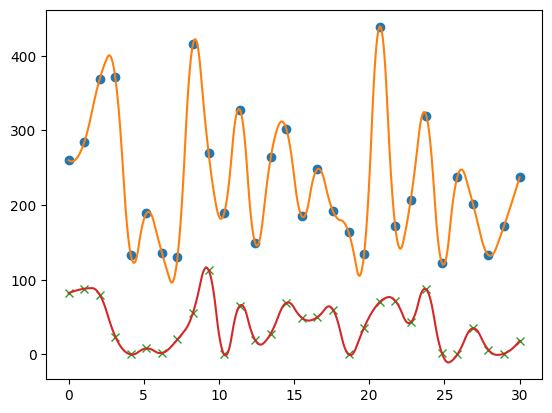

None
None
X_full.shape (901, 7)
y_full.shape (901,)
X_train.shape (801, 7)
y_train.shape (801,)
X_test.shape (100, 7)
y_test.shape (100,)
ERROR1 START
'Lars' object has no attribute 'best_estimator_'
ERROR1 FINISH
{'Model_train': Lars(n_nonzero_coefs=6, random_state=0), 'Predictors': 'S_2802, H_2802, X2, X3, Xs, L_2802', 'Equations': ' - 58.01 + 1.038*S_2802 + 0.374*H_2802 + 0.452*X2 + 0.342*X3 + 0.444*Xs + 1.42*L_2802', 'Forecast_year': 2024, 'Dataset_name': 'Вилия-Михалишки', 'Predictors_list': ['S_2802', 'H_2802', 'X2', 'X3', 'Xs', 'L_2802', 'Y_sum'], 'Norms_data': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0}, 'Group': 2, 'Method': 'Lars6', 'Sigma': 89.32302222188059, 'Sigma_t': 83.05365783672238, 'Delta_dop': 60.20371697754752, 'Delta_dop_t': 55.97816538195089, 'Pm': 73.33333333333333, 'Pm_t': 77.0, 'S': 50.13331151949707, 'S_t': 44.73775906501819, 'Criterion': 0.5612585677516003, 'Criterion_t': 0.5386609118766263, 'Correlation': 0.8276405138255511, 'Correlati

In [22]:
_ = train_models(2024, pr_group=None, n_test=100, norms=True, aug_n=1000, aug_pow=2, 
                 aug_mirror=False, grid_search=True, scaler_x=None, scaler_y=None, 
                 shuffle=True, serial=True)
